<a href="https://colab.research.google.com/github/Navarra2/ML/blob/master/CLAProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.linalg import logm
from scipy.sparse import diags, identity
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt
!pip install rogues
from rogues import wathen
from google.colab import files


In [ ]:
def gershgorin(A):
  '''
  Input : A nxn matrix
  Returns: extremities of Gershgorin discs
  '''
  abs_A = np.abs(A)
  radii = np.sum(abs_A, axis=1) - np.diagonal(abs_A)
  return np.min(np.diagonal(A) - radii), np.max(np.diagonal(A) + radii)

In [ ]:
def alg1(A,u,f,eps,maxit):
  "Algorithm 1 with Gauss-Radau quadrature"

  #find the values a and b bounds of the spectrum using the Gerschgorin circles
  a, b = gershgorin(A)
  if a <= 0:
    a = 1e-4

  #beginning of the Algorithm
  x_old = np.zeros_like(u)
  x_new = u/np.linalg.norm(u)
  gamma = np.zeros(maxit)
  alpha = np.zeros(maxit)
  Ia_old = -np.inf
  Ia_new = np.inf
  Ib_old = -np.inf
  Ib_new = np.inf
  j = 1
  while (j==1) or ((np.abs(Ia_old - Ia_new)/np.abs(Ia_new)>eps or np.abs(Ib_old - Ib_new)/np.abs(Ib_new)>eps) and j< maxit):
    #getting the values of alpha, gamma, r
    Ax = np.matmul(A,x_new)
    alpha[j] = np.matmul(x_new.transpose(),Ax)
    r_new = Ax - alpha[j]*x_new - gamma[j-1]*x_old
    gamma[j] = np.linalg.norm(r_new)
    gammaj = gamma[j]

    #construction of T^tilde
    Tj = np.diag(gamma[1:j],-1) + np.diag(alpha[1:j+1],0) + np.diag(gamma[1:j],1)
    ej = np.identity(j)[:,-1]

    
    Ta =Tj - a*np.identity(j)
    Tb = Tj - b*np.identity(j)

    #check if the matrices are non singular (this will not happen in general due to the interlacing property of the Tj's in A)
    if np.linalg.det(Ta)==0 or np.linalg.det(Tb)==0:
      break
      
    #extend matrix T to T_tilde
    deltaa = np.linalg.solve(Ta,(gammaj**2)*ej)
    deltab = np.linalg.solve(Tb,(gammaj**2)*ej)

    phia = deltaa[-1] + a
    phib = deltab[-1] + b

    ej = np.expand_dims(ej, axis=0)    
    Tj_tildea = np.block([
    [Tj,               gammaj*ej.transpose()],
    [gammaj*ej, phia               ]
])  
    Tj_tildeb = np.block([
    [Tj,               gammaj*ej.transpose()],
    [gammaj*ej, phib               ]
])  

    Ia_old = Ia_new
    Ib_old = Ib_new
    #compute I_j
    Ia_new = gauss_radau(Tj_tildea,f,a,b)
    Ib_new = gauss_radau(Tj_tildeb,f,a,b)

    x_old = x_new
    x_new = r_new/gammaj

    j+=1

  #Compute the estimates for lower and upper bounds
  U = Ia_new*np.linalg.norm(u)**2
  L = Ib_new*np.linalg.norm(u)**2

  if L<=U:
    return [L,U]
  else:
    return [U,L]


In [ ]:
def gauss_radau(T,f,a,b):
  "Computes the Gauss-Radau quadrature"
  teta, eigvec= np.linalg.eig(T)
  w = np.zeros_like(teta)
  I=0
  #normalize them to get w
  for i in range(np.shape(eigvec)[1]):
    vec = eigvec[:,i] 
    wi = (vec/np.linalg.norm(vec))[0]
    I += wi**2*f(teta[i])

  return I


In [ ]:
plt.style.use("seaborn-paper")
plt.style.use("seaborn-colorblind")
def alg2(A,f,m,p,eps,maxit):
  "Computes an unbiased estimator I_p of tr(A) and a confidence interval (L_p, U_p) with a user probability p"
  " It differs on the Algorithm 2 in the paper in step 7 where the bounds for the Hoeffding's Inequality are m*a and m*b and not Lmin and Umax"

  a, b = gershgorin(A)
  n = len(A)
  Lmin = np.inf
  Umax = -np.inf
  sumLj = 0
  sumUj = 0
  I = np.zeros(m)
  L = np.zeros(m)
  U = np.zeros(m)

  for j in range(m):
    zj = np.random.random_sample(n)
    for i in range(n):
      if zj[i]<0.5:
        zj[i] = -1
      else:
        zj[i] = 1
    S = alg1(A,zj,f,eps,maxit)
    sumLj =sumLj + S[0]
    sumUj =sumUj + S[1]
    I[j] = (sumUj + sumLj)/(2*(j+1))

    Lmin = min(Lmin,S[0])
    Umax = max(Umax,S[1])

    eta2 = -0.5*(j+1)*((n*b-n*a)**2)*(np.log(1-p)/2)
    L[j] = (sumLj - np.sqrt(eta2))/(j+1)
    U[j] = (sumUj +np.sqrt(eta2))/(j+1)

  return I,L,U

In [ ]:

'''
    plt.savefig("fig.pdf", format="pdf")
    files.download("fig.pdf") 
'''

In [ ]:
# small experiments
def f(x):
  return 1/x
def g(x):
  return np.log(x)
f(2)
A = [[1,0,0],[0,2,1],[0,1,1]]
B = [[1,0,0],[0,2,1],[0,1,1]]
eps = 1e-4
maxit = 50
u=[-1,-1,1]
alg1(B,u,f,eps,maxit)
np.log(B)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


array([[0.        ,       -inf,       -inf],
       [      -inf, 0.69314718, 0.        ],
       [      -inf, 0.        , 0.        ]])

In [ ]:
#small experiments
eps=1e-4
maxit=80
B = [[1,0,0],[0,2,1],[0,1,1]]
m=50
alg2(B,f,m,0.95,eps,maxit)

(array([6.        , 4.        , 3.33333333, 4.        , 3.6       ,
        4.        , 4.28571429, 4.        , 4.22222222, 4.        ,
        3.81818182, 3.66666667, 3.53846154, 3.42857143, 3.33333333,
        3.5       , 3.64705882, 3.55555556, 3.47368421, 3.6       ,
        3.71428571, 3.81818182, 3.73913043, 3.66666667, 3.76      ,
        3.69230769, 3.77777778, 3.85714286, 3.79310345, 3.86666667,
        3.80645161, 3.75      , 3.6969697 , 3.76470588, 3.71428571,
        3.77777778, 3.83783784, 3.78947368, 3.74358974, 3.8       ,
        3.85365854, 3.9047619 , 3.95348837, 3.90909091, 3.95555556,
        3.91304348, 3.95744681, 4.        , 3.95918367, 4.        ]),
 array([-123.8113787 ,  -87.79050615,  -71.6133011 ,  -60.90568935,
         -54.4534134 ,  -48.99527344,  -44.77837505,  -41.89525308,
         -39.04823734,  -37.04996229,  -35.32142151,  -33.80665055,
         -32.46473708,  -31.26497886,  -30.18382052,  -28.95284467,
         -27.83682505,  -27.04127983,  -26.307

In [ ]:
#Matrices needed for the Results of Paper 1
#Linear Heat Flow -Table 1
k = 30
v = 0.2
D = np.diag((1+4*v)*np.ones(k))+np.diag(-v*np.ones(k-1),1)+np.diag(-v*np.ones(k-1),-1)
C = np.diag(-v*np.ones(k-1),1)+np.diag(-v*np.ones(k-1),-1)

eps = 1e-4
maxit=50
LHF = np.kron(D,np.eye(C.shape[0],C.shape[1])) + np.kron(np.eye(D.shape[0],D.shape[1]),C)

print('Table 1')
print('[Lower Bound, Upper Bound] Estimate')
print('|U-L|')
index = [0,21,31]
for i in index:
  u = np.zeros(k*k)
  u[i]=1
  print(i+1)
  print(alg1(LHF,u,f,eps,maxit), np.linalg.inv(LHF)[i][i])
  print(alg1(LHF,u,f,eps,maxit)[1]-alg1(LHF,u,f,eps,maxit)[0])
  

Table 1
[Lower Bound, Upper Bound] Estimate
|U-L|
1
[0.5702011520873507, 0.5702020200496608] 0.5702015080939912
8.679623101359724e-07
22
[0.5780336923348436, 0.5780355849609463] 0.5780345194350731
1.8926261027285562e-06
32
[0.5862620904175381, 0.586264309495125] 0.5862630614261157
2.21907758690687e-06


Table 2
Lower Bound, Upper Bound, Estimate
|U-L|
[2, 1]
0.06590667884806001 0.06590692774260992 0.06590678642295984
2.4889454991461335e-07
[20, 21]
0.06683684158545827 0.0668372494954555 0.06683706149536885
4.079099972242872e-07
[200, 181]
0.0 0.0 1.6328011019249202e-17
0.0
[200, 700]
0.0 0.0 3.950902878020824e-19
0.0
[899, 895]
0.00011171703842782765 0.00011207641107380262 0.00011189572408953646
3.5937264597496466e-07
Table 6
logm result may be inaccurate, approximate err = 2.3172985283392525e-13
Trace(Log(LHF))
506.2524211326222


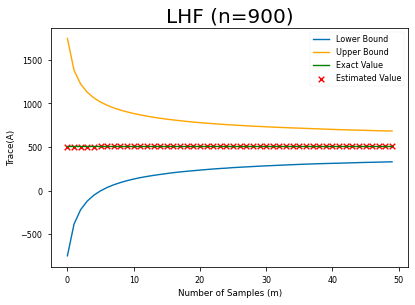

Lower Bound, Upper Bound, Estimate
329.8708092203036 682.3468853713391 506.1088472958214


In [ ]:
#Linear Heat Flow -Table 2
k = 30
v = 0.2
D = np.diag((1+4*v)*np.ones(k))+np.diag(-v*np.ones(k-1),1)+np.diag(-v*np.ones(k-1),-1)
C = np.diag(-v*np.ones(k-1),1)+np.diag(-v*np.ones(k-1),-1)

eps = 1e-4
LHF = np.kron(D,np.eye(C.shape[0],C.shape[1])) + np.kron(np.eye(D.shape[0],D.shape[1]),C)

index = [[2,1],[20,21],[200,181],[200,700],[899,895]]
print('Table 2')
print('Lower Bound, Upper Bound, Estimate')
print('|U-L|')
for i in index:
  u=np.zeros(k*k)
  v=np.zeros(k*k)
  print(i)
  u[i[0]-1]=1
  v[i[1]-1]=1
  y=u+v
  z=u-v
  L1,U1 = alg1(LHF,y,f,eps,maxit)
  L2,U2 = alg1(LHF,z,f,eps,maxit)
  print((L1-L2)/4,(U1-U2)/4, np.linalg.inv(LHF)[i[0]-1][i[1]-1])
  print((U1-U2)/4 - (L1-L2)/4)


print('Table 6')
eps=1e-4
maxit=60
m= 50
I,L,U=alg2(LHF,g,m,0.95,eps,maxit)
tr = np.trace(logm(LHF))
Ip = I[-1]
Lp = L[-1]
Up = U[-1]
print('Trace(Log(LHF))')
print(tr)
plt.figure()
plt.plot(range(m), L)
plt.plot(range(m), U,color = "orange")
plt.plot(range(m), tr*np.ones(m),color = "green")
plt.scatter(range(m), I,marker='x',color = "red")
plt.legend(["Lower Bound","Upper Bound","Exact Value","Estimated Value"])
plt.xlabel('Number of Samples (m)')
plt.ylabel('Trace(A)')
plt.title("LHF (n=900)", fontsize=20)
plt.show()
print('Lower Bound, Upper Bound, Estimate')
print(Lp,Up,Ip)

Condition Number
388.81213449326515
Table 3
Lower Bound, Upper Bound
|U-L|
[2, 1]
0.10468556047136147 0.10872288168353057
0.004037321212169098
[1, 900]
4.808133278744187e-07 0.0003335670000787494
0.000333086186750875
[10, 90]
0.00030261291436231574 0.020224455199052443
0.019921842284690128
[41, 42]
0.22903921509429026 0.50208715932378
0.27304794422948975
[58, 59]
0.1920559709963296 0.22870988006013815
0.036653909063808554
[450, 449]
0.17883659204334534 0.34101737585433556
0.16218078381099021
[550, 750]
0.004114977504218353 0.08432783998073856
0.08021286247652021
[600, 602]
0.0008095393919612948 0.08883187494104999
0.0880223355490887
[650, 750]
0.01618157471580084 0.16180821065397322
0.14562663593817238
Table 5
Trace(Poisson)
512.6441819996355


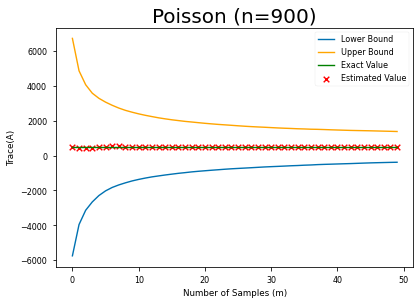

Lower Bound, Upper Bound, Estimate
-383.9039851000448 1378.5692850488444 497.3326499743998
Table 6
logm result may be inaccurate, approximate err = 3.013873461987071e-13
Trace(Log(Poisson))
1065.0006883542387


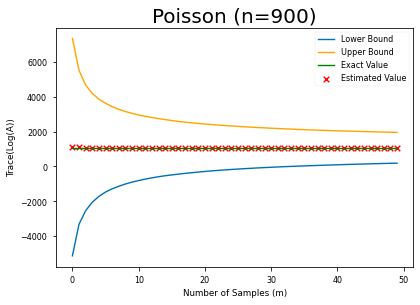

Lower Bound, Upper Bound, Estimate
187.4772695466678 1950.320323476178 1068.898796511423


In [ ]:
#Poisson Matrix
k=30
eps = 1e-4
maxit=30
T =diags([2*np.ones(k),-1*np.ones(k), -1*np.ones(k)], offsets=[0, -1, 1]).A
I = np.eye(k,k)
Poisson = np.kron(T,I) + np.kron(I,T)
index = [[2,1],[1,900],[10,90],[41,42],[58,59],[450,449],[550,750],[600,602],[650,750]]
print("Condition Number")
print(np.linalg.cond(Poisson))
print('Table 3')
print('Lower Bound, Upper Bound')
print('|U-L|')
for i in index:
  u=np.zeros(k*k)
  v=np.zeros(k*k)
  print(i)
  u[i[0]-1]=1
  v[i[1]-1]=1
  y=u+v
  z=u-v
  L1,U1 = alg1(Poisson,y,f,eps,maxit)
  L2,U2 = alg1(Poisson,z,f,eps,maxit)
  print((L1-L2)/4,(U1-U2)/4)
  print((U1-U2)/4 - (L1-L2)/4)


print('Table 5')
eps=1e-4
maxit=60
m= 50
I,L,U=alg2(Poisson,f,m,0.95,eps,maxit)
Ip = I[-1]
Lp = L[-1]
Up = U[-1]
tr = np.trace(np.linalg.inv(Poisson))
print('Trace(Poisson)')
print(tr)
plt.plot(range(m), L)
plt.plot(range(m), U,color = "orange")
plt.plot(range(m), tr*np.ones(m),color = "green")
plt.scatter(range(m), I,marker='x',color = "red")
plt.legend(["Lower Bound","Upper Bound","Exact Value","Estimated Value"])
plt.xlabel('Number of Samples (m)')
plt.ylabel('Trace(A)')
plt.title("Poisson (n=900)", fontsize=20)
plt.show()

print('Lower Bound, Upper Bound, Estimate')
print(Lp,Up,Ip)


print('Table 6')
eps=1e-4
maxit=60
m= 50
I,L,U = alg2(Poisson,g,m,0.95,eps,maxit)
Ip = I[-1]
Lp = L[-1]
Up = U[-1]
tr = np.trace(logm(Poisson))
print('Trace(Log(Poisson))')
print(tr)
plt.plot(range(m), L)
plt.plot(range(m), U,color = "orange")
plt.plot(range(m), tr*np.ones(m),color = "green")
plt.scatter(range(m), I,marker='x',color = "red")
plt.legend(["Lower Bound","Upper Bound","Exact Value","Estimated Value"])
plt.xlabel('Number of Samples (m)')
plt.ylabel('Trace(Log(A))')
plt.title("Poisson (n=900)", fontsize=20)
plt.show()

print('Lower Bound, Upper Bound, Estimate')
print(Lp,Up,Ip)

Table 5
Trace(Wathen)
35.393837021856186


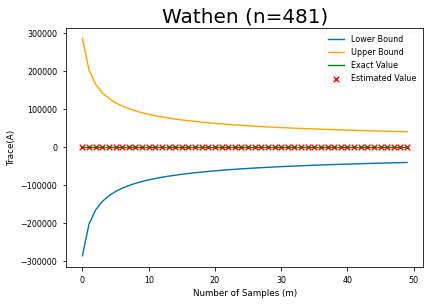

Lower Bound, Upper Bound, Estimate
-40403.059106139975 40487.073108809345 42.007001334685526


In [ ]:
#Wathen Matrix

Wathen = wathen(12, 12).A
print('Table 5')
eps=1e-4
maxit=60
m= 50
np.trace(np.linalg.inv(Wathen))
I,L,U = alg2(Wathen,f,m,0.95,eps,maxit)
Ip = I[-1]
Lp = L[-1]
Up = U[-1]
tr = np.trace(np.linalg.inv(Wathen))
print('Trace(Wathen)')
print(tr)
plt.plot(range(m), L)
plt.plot(range(m), U,color = "orange")
plt.plot(range(m), tr*np.ones(m),color = "green")
plt.scatter(range(m), I,marker='x',color = "red")
plt.legend(["Lower Bound","Upper Bound","Exact Value","Estimated Value"])
plt.xlabel('Number of Samples (m)')
plt.ylabel('Trace(A)')
plt.title("Wathen (n=481)", fontsize=20)
plt.show()
print('Lower Bound, Upper Bound, Estimate')
print(Lp,Up,Ip)

Table 5
Trace(Lehmer)
20001.815457108554


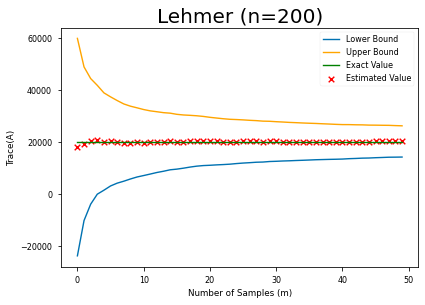

Lower Bound, Upper Bound, Estimate
14197.812984256412 26246.22797791116 20222.020481083786


In [ ]:
#Lehmer Matrix
n=200
Lehmer = np.zeros((n,n))
for i in range(n):
  for j in range(n):
    if i<=j:
      Lehmer[i][j] = (i+1)/(j+1)
    else:
      Lehmer[i][j] = (j+1)/(i+1)
print('Table 5')
eps=1e-4
maxit=90
m= 50
I,L,U= alg2(Lehmer,f,m,0.95,eps,maxit)
Ip = I[-1]
Lp = L[-1]
Up = U[-1]
tr = np.trace(np.linalg.inv(Lehmer))
print('Trace(Lehmer)')
print(tr)
plt.plot(range(m), L)
plt.plot(range(m), U,color = "orange")
plt.plot(range(m), tr*np.ones(m),color = "green")
plt.scatter(range(m), I,marker='x',color = "red")
plt.legend(["Lower Bound","Upper Bound","Exact Value","Estimated Value"])
plt.xlabel('Number of Samples (m)')
plt.ylabel('Trace(A)')
plt.title("Lehmer (n=200)", fontsize=20)
plt.show()
print('Lower Bound, Upper Bound, Estimate')
print(Lp,Up,Ip)

Table 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: ComplexWarning: Casting complex values to real discards the imaginary part


Trace(Log(Pei))
5.707110264748825


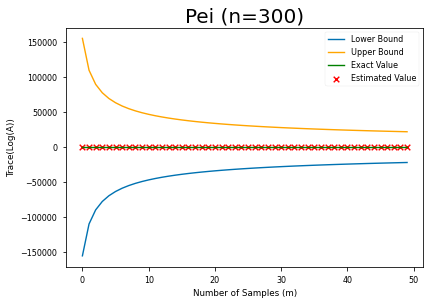

Lower Bound, Upper Bound, Estimate
-21951.926650937447 21961.00716266143 4.54025586199304


In [ ]:
#Pei Matrix
n= 300
alpha = 1
Pei = alpha*np.identity(n)+np.ones((n,n))
print('Table 6')
m=50
eps = 1e-4
maxit = 60
I,L,U = alg2(Pei,g,m,0.95,eps,maxit)
tr = np.trace(logm(Pei))
Ip = I[-1]
Lp = L[-1]
Up = U[-1]
print('Trace(Log(Pei))')
print(tr)
plt.plot(range(m), L)
plt.plot(range(m), U,color = "orange")
plt.plot(range(m), tr*np.ones(m),color = "green")
plt.scatter(range(m), I,marker='x',color = "red")
plt.legend(["Lower Bound","Upper Bound","Exact Value","Estimated Value"])
plt.xlabel('Number of Samples (m)')
plt.ylabel('Trace(Log(A))')
plt.title("Pei (n=300)", fontsize=20)
plt.show()
print('Lower Bound, Upper Bound, Estimate')
print(Lp,Up,Ip)

# Timing the functions

In [ ]:
def n_systems(A):
  n = len(A)
  trace = 0
  for i in range(n):
    ei = np.identity(n)[:, i]
    trace += np.dot(ei, np.linalg.solve(A, ei))
  return trace

def t(A):
  return np.trace(np.linalg.inv(A))

def using_alg1(A, eps=1e-4, maxit=100):
  n = len(A)
  lsum = 0
  usum = 0
  for i in range(n):
    ei = np.identity(n)[:, i]
    l, u = alg1(A, ei, f, eps, maxit)
    lsum += l
    usum += u
  return lsum, usum

def using_alg2(A, eps=1e-4, maxit=100):
  m = int(0.2*len(A))
  p = 0.95
  f = lambda x: 1/x
  return alg2(A, f, m, p, eps, maxit)

In [ ]:
#Creates LHF matrix
k = 20
v = 0.2
D = np.diag((1+4*v)*np.ones(k))+np.diag(-v*np.ones(k-1),1)+np.diag(-v*np.ones(k-1),-1)
C = np.diag(-v*np.ones(k-1),1)+np.diag(-v*np.ones(k-1),-1)

eps = 1e-4
LHF = np.kron(D,np.eye(C.shape[0],C.shape[1])) + np.kron(np.eye(D.shape[0],D.shape[1]),C)

A = LHF

import timeit
print("Trace of inverse : ", timeit.timeit('t(A)', globals=globals(), number=10)/10)
print("N system solves : ", timeit.timeit('n_systems(A)', globals=globals(), number=10)/10)
for eps in [1e-1, 1e-3, 1e-6, 1e-9] :
  print("EPSILON", eps)
  print("\t Using Algorithm 1 (epsilon : {}): ".format(eps), timeit.timeit('using_alg1(A, eps, 100)', globals=globals(), number=10)/10)
  print("\t Using Algorithm 2 (epsilon : {}): ".format(eps), timeit.timeit('using_alg2(A, eps, 100)', globals=globals(), number=10)/10)

Trace of inverse :  0.010854810399905546
N system solves :  1.7533345027000906
EPSILON 0.1
	 Using Algorithm 1 (epsilon : 0.1):  0.9553830028999073
	 Using Algorithm 2 (epsilon : 0.1):  0.19834229549996962
EPSILON 0.001
	 Using Algorithm 1 (epsilon : 0.001):  1.6004138624000916
	 Using Algorithm 2 (epsilon : 0.001):  0.3022426094998082
EPSILON 1e-06
	 Using Algorithm 1 (epsilon : 1e-06):  2.4585146442001133
	 Using Algorithm 2 (epsilon : 1e-06):  0.48615675219989496
EPSILON 1e-09
	 Using Algorithm 1 (epsilon : 1e-09):  3.3271499741997106
	 Using Algorithm 2 (epsilon : 1e-09):  0.6683842999002081
